In [ ]:
#load my library
!pip install decoders==0.1.4

In [1]:
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm
from decoders.strategies.sbs_helpers.logits_process import LogitsProcessorList, TemperatureLogitsWarper, LogitsProcessor
from decoders import inject_supervitamined_decoders, StochasticBeamSearchDecoder, toolbox, SmallProbTransformer, SmallProbTransformerConfig
from decoders.simple.beam_search import BeamSearchDecoder
from decoders.simple.stochastic_beam_search import SimpleSBSLogitProcessor, SimpleStochasticBeamSearchDecoder
from decoders import inject_supervitamined_decoders
from transformers import GenerationConfig, AutoTokenizer, AutoModelForSeq2SeqLM

from decoders.strategies.sbs_helpers.logits_process import LogitsProcessorList

type_t = torch.float64
torch.set_default_dtype(type_t)

# Ancestral samples

In [16]:
config = SmallProbTransformerConfig()
model = SmallProbTransformer(config)
inject_supervitamined_decoders(model)

R=10
a_input_ids = torch.tensor([[-2]] * R) #this is faster than num_return_sequences=R

def ancestral_sample():
  return model.generate(a_input_ids,
                        num_beams=1, num_return_sequences=1,
                        do_sample=True, return_dict_in_generate=True,
                        output_scores=True)

In [17]:
# sequences[:, 1] are the first tokens of the sequence.
#
first_tokens_bincount = ancestral_sample().sequences[:, 1].bincount()
print(f"routes bincount: {first_tokens_bincount}, total: {first_tokens_bincount.sum()}")

routes bincount: tensor([1, 1, 0, 2, 0, 2, 2, 2]), total: 10


As you see, there the generated sentences follow the 10% probability of the first token being 0,1,...,9.

# SBS sampling

## Gumbel sampling code

In [ ]:
# Gumbel code

def gumbel_like(*args, **kwargs):
    return _gumbel(torch.rand_like(*args, **kwargs))

def gumbel(*args, **kwargs):
    return _gumbel(torch.rand(*args, **kwargs))


def _gumbel(u):
    return -torch.log(-torch.log(u))


def gumbel_with_maximum(phi, T, dim=-1):
    """
    Samples a set of gumbels which are conditioned on having a maximum along a dimension
    phi.max(dim)[0] should be broadcastable with the desired maximum T
    """

    # if ((-1e9 < phi) & (phi< -100)).any():
    #     print("habemus problemus")


    # Gumbel with location phi
    g_phi = phi + gumbel_like(phi)
    Z, argmax = g_phi.max(dim)
    g = _shift_gumbel_maximum(g_phi, T, dim, Z=Z)
    CHECK_VALIDITY = False
    if CHECK_VALIDITY:
        g_inv = _shift_gumbel_maximum(g, Z, dim)
        # Create a boolean mask where the condition fails
        mask = ~(((g_phi - g_inv) < 1e-3) | (g_phi == g_inv))

        # Get indices where the mask is True (i.e., the assertion fails)
        fail_indices = torch.nonzero(mask, as_tuple=True)

        # Print the failed indices and corresponding values
        for ind in zip(*fail_indices):
            print(f"Index: {ind}, g_phi value: {g_phi[ind]}, g_inv value: {g_inv[ind]}, dif: {g_phi[ind]-g_inv[ind]:.4f}")

        # assert torch.all(((g_phi - g_inv) < 1e-3) | (g_phi == g_inv))
    return g, argmax


def _shift_gumbel_maximum(g_phi, T, dim=-1, Z=None):
    if Z is None:
        Z, _ = g_phi.max(dim)
    u = T.unsqueeze(dim) - g_phi + torch.log1p(-torch.exp(g_phi - Z.unsqueeze(dim)))
    return T.unsqueeze(dim) - F.relu(u) - torch.log1p(torch.exp(-u.abs()))

## Main Stochastic Beam Search sampling code

In [ ]:
class SBSLogitProcessor(LogitsProcessor):

    def __init__(self, num_beams, batch_size=2):
        self.num_beams = num_beams
        self.batch_size = batch_size

    def __call__(self, input_ids, scores, **kwargs):
        """

        :param input_ids: shape (batch_size * num_beams, seq_len)
        :param scores: shape (batch_size * num_beams, vocab_size)
        :param kwargs.beam_log_probs: shape (batch_size * num_beams,)
        :param kwargs.past_processed_scores: tuple of size seq_len with tensors (batch_size * num_beams, vocab_size)
        :return: shape (batch_size, vocab_size)
        """

        assert kwargs.get('beam_log_probs', None) is not None, "beam_log_probs must be provided"
        assert kwargs.get('past_scores', None) is not None, "past_scores is None. Add output_" \
                                                                      "scores=True to the generate function arguments"
        assert kwargs.get('beam_indices', None) is not None, "beam_indices must be provided"
        beam_log_probs = kwargs['beam_log_probs']  # shape (batch_size * num_beams,)
        beam_log_probs = beam_log_probs.view(-1,1)  # shape (batch_size * num_beams,)
        past_scores = kwargs['past_scores']  # tuple: seq_len tensors of dim (batch_size * num_beams, vocab_size)
        beam_indices = kwargs['beam_indices']  # shape (batch_size * num_beams,)

        device = input_ids.device

        scores = beam_log_probs.view(-1, 1) + scores  # shape (batch_size * num_beams, vocab_size)
        scores = scores.clamp(min=-1e9)

        if len(past_scores) == 0:  # first token
            last_gumbels = gumbel(size=(self.batch_size,)).to(device)  # shape (batch_size, )
            # expand (batch_size, ) to (batch_size * num_beams, )
            last_gumbels = last_gumbels.repeat_interleave(self.num_beams, dim=0)
        else:
            last_token_scores = past_scores[-1]  # shape (batch_size * num_beams, vocab_size)
            last_tokens = input_ids[:, -1]  # shape (batch_size * num_beams, )
            last_beam_indices = torch.tensor(tuple(tup[-1] for tup in beam_indices), device=device)
            last_gumbels = last_token_scores[last_beam_indices, last_tokens]
        new_gumbels, _ = gumbel_with_maximum(scores, last_gumbels)  # shape (batch_size * num_beams, ) todo check this view
        return new_gumbels

In [18]:
sbs_input_ids = torch.tensor([[-2]])
num_samples = 100
def sbs_sample():
  return model.generate(sbs_input_ids,
                             generation_strategy=BeamSearchDecoder(),
                             generation_config=GenerationConfig(max_new_tokens=100, num_beams=10, num_return_sequences=10),
                             logits_processor=LogitsProcessorList([SimpleSBSLogitProcessor()]),
                             )
output = sbs_sample()
# print(f"generated tokens: {output.sequences}")
# print(f"routes: {output.sequences[:, 1]}")
routes_freq = output.sequences[:, 1].bincount(minlength=config.real_vocab_size)
print(f"routes bincount: {routes_freq}, total: {routes_freq.sum()}")

routes bincount: tensor([2, 1, 1, 0, 0, 1, 1, 1, 1, 2]), total: 10


In [ ]:
torch.zeros((5,5)).dtype

torch.float64

In [ ]:
output.sequences_scores.dtype

torch.float32

In [19]:
sbs_l = []
ancestral_l = []
for i in tqdm(range(1000)):
  out_a = ancestral_sample().sequences[:, 1]
  out_sbs = sbs_sample().sequences[:, 1]
  sbs_l.extend(out_sbs.tolist())
  ancestral_l.extend(out_a.tolist())

  0%|          | 0/1000 [00:00<?, ?it/s]

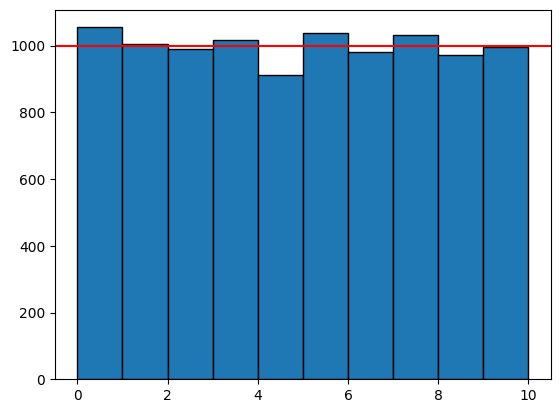

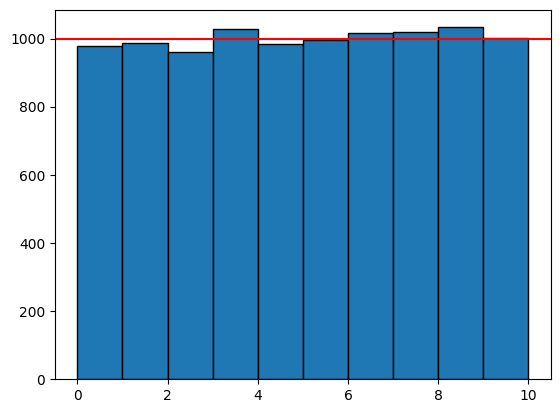

In [20]:
import matplotlib.pyplot as plt

plt.hist(sbs_l, bins=range(11), edgecolor='black')
plt.axhline(y=1000, color='red', linestyle='-')
plt.show()

plt.hist(ancestral_l, bins=range(11), edgecolor='black')
plt.axhline(y=1000, color='red', linestyle='-')
plt.show()